In [34]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Normalization, Resizing
from tensorflow.keras import layers
from tensorflow.keras import models
import pandas as pd

import seaborn as sns

from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch, periodogram

In [ ]:
print(tf.__version__)

In [ ]:
import os
os.getcwd()

In [35]:
df_scratch = pd.read_csv('data\\emg_scratch.csv')
df_rest = pd.read_csv('data\\emg_rest.csv')
df_other = pd.read_csv('data\\emg_other.csv')
df_scratch

df_rest_400Hz = pd.read_csv('data\\400Hz\\emg_rest_400Hz.csv')
df_scratch_400Hz = pd.read_csv('data\\400Hz\\emg_scratch_400Hz.csv')
df_other_400Hz = pd.read_csv('data\\400Hz\\emg_other_400Hz.csv')

df_rest_800Hz = pd.read_csv('data\\800Hz\\emg_rest_800Hz.csv')
df_scratch_800Hz = pd.read_csv('data\\800Hz\\emg_scratch_800Hz.csv')
df_other_800Hz = pd.read_csv('data\\800Hz\\emg_other_800Hz.csv')

In [36]:
scratch_data = df_scratch['v2'].to_numpy()[0:1051]
other_data = df_other['v2'].to_numpy()[0:1051]
rest_data = df_rest['v2'].to_numpy()[0:1051]

rest_data_400Hz = df_rest_400Hz['v2'].to_numpy()
scratch_data_400Hz = df_scratch_400Hz['v2'].to_numpy()
other_data_400Hz = df_other_400Hz['v2'].to_numpy()

rest_data_800Hz = df_rest_800Hz['v2'].to_numpy()
scratch_data_800Hz = df_scratch_800Hz['v2'].to_numpy()  
other_data_800Hz = df_other_800Hz['v2'].to_numpy()

scratch_data_v = df_scratch['v2'].to_numpy()[1051:]
other_data_v = df_other['v2'].to_numpy()[1051:]
rest_data_v = df_rest['v2'].to_numpy()[1051:]

In [37]:
def normalize(data):
    data = data - np.mean(data)
    data = (data - data.min()) / (data.max() - data.min())
    return data

def bandpass_filter(data, lowcut=20.0, highcut=90.0, fs=200.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data)

def find_noise_frequency(data, fs=200.0):
    f, Pxx = periodogram(data, fs=fs)
    idx = np.argmax(Pxx)
    return f[idx]

def adaptive_notch_filter(data, fs=200.0, quality=30):
    freq = find_noise_frequency(data, fs=fs)
    nyq = 0.5 * fs
    b, a = iirnotch(freq/nyq, quality)
    return filtfilt(b, a, data)

def cleanup(data):
    data = normalize(data)
    data = bandpass_filter(data)
    data = adaptive_notch_filter(data)
    return data

In [ ]:
def stft(x, sampling_rate=1000):
    f, t, spec = signal.stft(x.numpy(), fs=sampling_rate, nperseg=128, noverlap = 64, nfft=128, boundary='zeros')
    return tf.convert_to_tensor(np.abs(spec))

def stft_full(x, sampling_rate=1000): # for visualization
    f, t, spec = signal.stft(x.numpy(), fs=sampling_rate, nperseg=128, noverlap = 64, nfft=128, boundary='zeros')
    return f, t, tf.convert_to_tensor(np.abs(spec))

def get_spectrogram(data: np.ndarray):
    # f, t, z = signal.stft(data, fs=200, nperseg=128, noverlap=50, nfft=128)
    spectrogram = tf.py_function(func=stft, inp=[data], Tout=tf.float32)
    # spectrogram.set_shape((129, 124))
    return spectrogram

(65, 8)


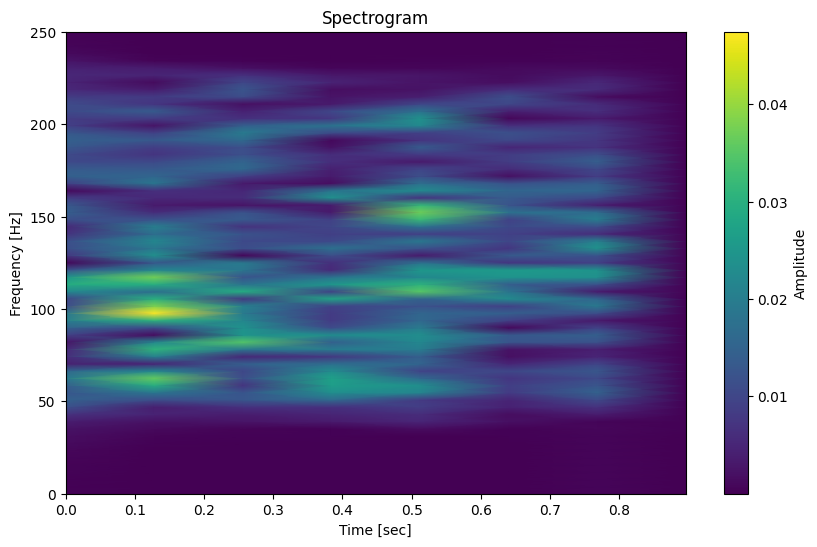

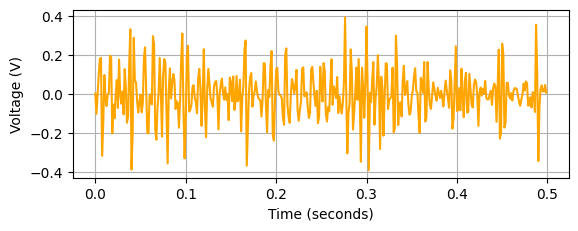

In [43]:
current_array = scratch_data_800Hz[100:500]
# print(rest_data_400Hz.shape)
cleaned = cleanup(current_array)
cleaned = tf.convert_to_tensor(cleaned, dtype=tf.float32)
f, t, spec = stft_full(cleaned, sampling_rate=500)
s = get_spectrogram(cleaned)
# print(f, t)
print(s.shape)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, s, shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Amplitude')  # limit frequency range to make plot clearer
# plt.savefig('scratch_data_800Hz.png')
plt.show()


time = np.arange(len(current_array)) / 800.0  

plt.subplot(2, 1, 2)
plt.plot(time, cleaned, label='Centered EMG Voltage', color='orange')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (seconds)')

plt.grid(True)

In [15]:
# helper functions to train the model

def get_sample(data, start, sampling_rate=1000):
    end = start + sampling_rate
    return data[start:end]

def get_data(filepath):
    df = pd.read_csv(filepath)
    return df[['v1', 'v2', 'label']].to_numpy()

def clean_data(data: np.ndarray):
    v1 = data[:, 0]
    v2 = data[:, 1]
    labels = data[:, 2]

    v1_cleaned = cleanup(v1)
    v2_cleaned = cleanup(v2)

    return np.column_stack((v1_cleaned, v2_cleaned, labels))

def get_spectrograms(data: np.ndarray, sampling_rate=1000, verbose=False):

    v1 = data[:, 0]
    v2 = data[:, 1]
    labels = data[:, 2]

    num_samples = data.shape[0]

    all_spec = []
    all_labels = []

    for i in range(0, (num_samples - int(sampling_rate / 2)) + 1, int(sampling_rate / 4)):
        
        sample1 = get_sample(v1, i, sampling_rate=int(sampling_rate / 2))
        # print(len(sample1))
        sample2 = get_sample(v2, i, sampling_rate=int(sampling_rate / 2))

        if verbose:
            print(f"Processing sample {i} to {i + int(sampling_rate / 2)}")
            # print(sample1, sample2)
        
        # print(sample1.shape, sample2.shape)
        sample1 = tf.convert_to_tensor(sample1, dtype=tf.float32)
        sample2 = tf.convert_to_tensor(sample2, dtype=tf.float32)

        spec1 = get_spectrogram(sample1)
        spec2 = get_spectrogram(sample2)
        
        sample = tf.stack([spec1, spec2], axis=1)
        all_spec.append(sample)
        all_labels.append(tf.cast(labels[i], tf.int32))

    # print(all_spec, all_labels)

    return tf.stack(all_spec, axis=0), tf.stack(all_labels, axis=0)

def split_data(data: np.ndarray, split_ratio=0.8):
    num_samples = data.shape[0]
    split_index = int(num_samples * split_ratio)
    
    train_data = data[:split_index]
    test_data = data[split_index:]
    
    return train_data, test_data


In [ ]:
# training on 5 seconds of data

scratch_data = get_data('data\\800Hz\\emg_scratch_800Hz.csv')
rest_data = get_data('data\\800Hz\\emg_rest_800Hz.csv')
other_data = get_data('data\\800Hz\\emg_other_800Hz.csv')

scratch_data = clean_data(scratch_data)
rest_data = clean_data(rest_data)
other_data = clean_data(other_data)
# print(scratch_df.shape)

# split into training and validation
df_scratch_train, df_scratch_test = split_data(scratch_data)
df_rest_train, df_rest_test = split_data(rest_data)
df_other_train, df_other_test = split_data(other_data)

specs, labels = get_spectrograms(scratch_data, verbose=True)
df_scratch_train

In [16]:
scratch_data = np.vstack([get_data('data\\training_set_15-07-2025\\emg_scratching_ariel.csv'),
    get_data('data\\training_set_15-07-2025\\emg_scratching_raina.csv')])

rest_data = np.vstack([get_data('data\\training_set_15-07-2025\\emg_rest_ariel.csv'),
    get_data('data\\training_set_15-07-2025\\emg_rest_raina.csv')])

other_data = np.vstack([get_data('data\\training_set_15-07-2025\\emg_other_ariel.csv'),
    get_data('data\\training_set_15-07-2025\\emg_other_raina.csv')])

print(scratch_data.shape, rest_data.shape, other_data.shape)

scratch_data = clean_data(scratch_data)
rest_data = clean_data(rest_data)   
other_data = clean_data(other_data)

# print(scratch_data)

df_scratch_train, df_scratch_test = split_data(scratch_data)
df_rest_train, df_rest_test = split_data(rest_data)
df_other_train, df_other_test = split_data(other_data)

(667000, 3) (667000, 3) (667000, 3)


In [17]:
# dataset manipulation bit
spec_scratch_train, scratch_labels = get_spectrograms(df_scratch_train, sampling_rate=1000, verbose=True)
spec_rest_train, rest_labels = get_spectrograms(df_rest_train, sampling_rate=1000)
spec_other_train, other_labels = get_spectrograms(df_other_train, sampling_rate=1000)

spec_scratch_test, scratch_labels_test = get_spectrograms(df_scratch_test, sampling_rate=1000)
spec_rest_test, rest_labels_test = get_spectrograms(df_rest_test, sampling_rate=1000)
spec_other_test, other_labels_test = get_spectrograms(df_other_test, sampling_rate=1000)

print(spec_scratch_train[0].shape)

ds_scratch_train = tf.data.Dataset.from_tensor_slices((spec_scratch_train, scratch_labels))
ds_rest_train = tf.data.Dataset.from_tensor_slices((spec_rest_train, rest_labels))
ds_other_train = tf.data.Dataset.from_tensor_slices((spec_other_train, other_labels))

ds_scratch_test = tf.data.Dataset.from_tensor_slices((spec_scratch_test, scratch_labels_test))
ds_rest_test = tf.data.Dataset.from_tensor_slices((spec_rest_test, rest_labels_test))
ds_other_test = tf.data.Dataset.from_tensor_slices((spec_other_test, other_labels_test))

spec_all_train = tf.concat([spec_scratch_train, spec_rest_train, spec_other_train], axis=0)
label_all_train = tf.concat([scratch_labels, rest_labels, other_labels], axis=0)

spec_all_test = tf.concat([spec_scratch_test, spec_rest_test, spec_other_test], axis=0)
label_all_test = tf.concat([scratch_labels_test, rest_labels_test, other_labels_test], axis=0)

complete_training_set = ds_scratch_train.concatenate(ds_rest_train).concatenate(ds_other_train)
complete_test_set = ds_scratch_test.concatenate(ds_rest_test).concatenate(ds_other_test)



Processing sample 0 to 500
Processing sample 250 to 750
Processing sample 500 to 1000
Processing sample 750 to 1250
Processing sample 1000 to 1500
Processing sample 1250 to 1750
Processing sample 1500 to 2000
Processing sample 1750 to 2250
Processing sample 2000 to 2500
Processing sample 2250 to 2750
Processing sample 2500 to 3000
Processing sample 2750 to 3250
Processing sample 3000 to 3500
Processing sample 3250 to 3750
Processing sample 3500 to 4000
Processing sample 3750 to 4250
Processing sample 4000 to 4500
Processing sample 4250 to 4750
Processing sample 4500 to 5000
Processing sample 4750 to 5250
Processing sample 5000 to 5500
Processing sample 5250 to 5750
Processing sample 5500 to 6000
Processing sample 5750 to 6250
Processing sample 6000 to 6500
Processing sample 6250 to 6750
Processing sample 6500 to 7000
Processing sample 6750 to 7250
Processing sample 7000 to 7500
Processing sample 7250 to 7750
Processing sample 7500 to 8000
Processing sample 7750 to 8250
Processing sampl

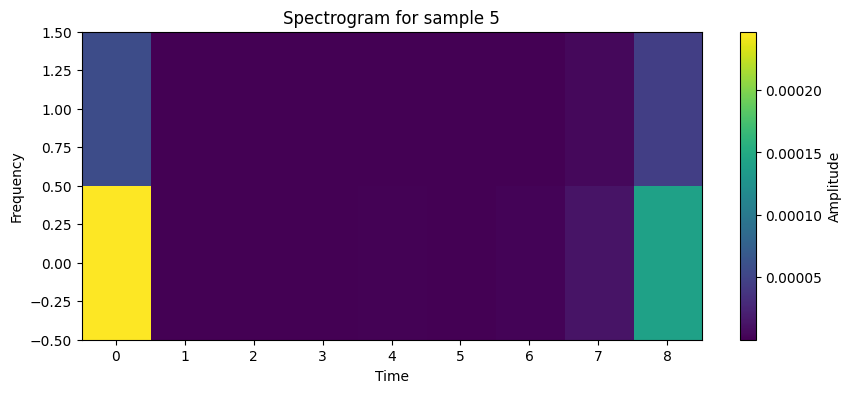

In [44]:
index = 5

spec = spec_scratch_train[index][0].numpy()

plt.figure(figsize=(10, 4))
plt.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title(f"Spectrogram for sample {index}")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [18]:
for spectrogram, label in complete_training_set.take(1):
    print("Spectrogram shape:", spectrogram.shape)
    print("Label:", label.numpy())

Spectrogram shape: (65, 2, 9)
Label: 1


In [22]:
input_shape = spec_all_train[0].shape

norm_layer = Normalization()
norm_layer.adapt(ds_scratch_train.map(lambda x, _: x))

size = tf.data.experimental.cardinality(complete_test_set).numpy()
print("Dataset size:", size)

size = tf.data.experimental.cardinality(complete_training_set).numpy()
print("Dataset size:", size)

batch_size = 32
train_ds = complete_training_set.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = complete_test_set.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Training dataset size:", val_ds)

model = models.Sequential([
    layers.Input(shape=input_shape),
    Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)  # Assuming 3 classes: scratch, rest, other
])

model.summary()

Dataset size: 1596
Dataset size: 6399
Training dataset size: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 65, 2, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 9)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 9)      │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,286 (6.21 MB)

 Trainable params: 1,627,267 (6.21 MB)

 Non-trainable params: 19 (80.00 B)

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9243 - loss: 0.8168 - val_accuracy: 0.6654 - val_loss: 1.8235
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7330 - loss: 0.7561 - val_accuracy: 0.6642 - val_loss: 1.5515
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8489 - loss: 0.5137 - val_accuracy: 0.6648 - val_loss: 1.7925
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8300 - loss: 0.6745 - val_accuracy: 0.6942 - val_loss: 2.0213
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8261 - loss: 0.5905 - val_accuracy: 0.6742 - val_loss: 2.2772
Epoch 5: early stopping


In [ ]:
model.save('first_9412_accuracy.keras')

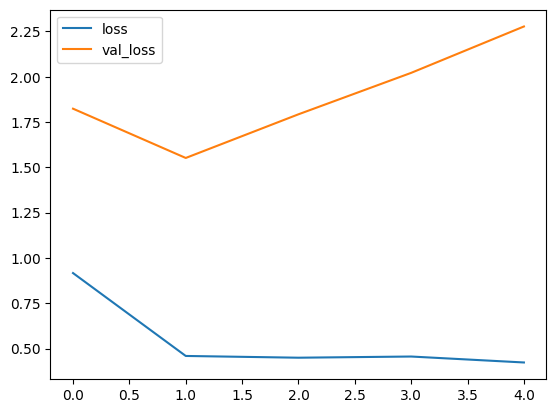

In [25]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.savefig('loss_plot_9412.png')
plt.show()

In [26]:
val_ds = complete_test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

y_pred = np.argmax(model.predict(val_ds.map(lambda x, y: x)), axis=1)
y_labels = label_all_test.numpy()

test_acc = sum(y_pred == y_labels) / len(y_pred)
print(f'Test set accuracy: {test_acc:.0%}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test set accuracy: 67%


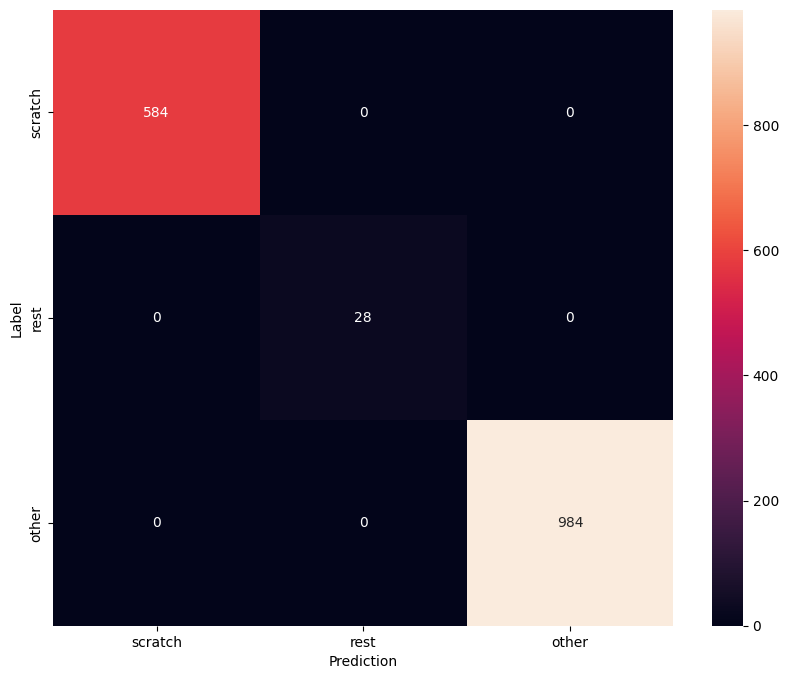

In [27]:
commands = ['scratch', 'rest', 'other']
confusion_mtx = tf.math.confusion_matrix(y_pred, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
model = tf.keras.models.load_model("first_9412_accuracy.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('test_model.tflite', 'wb') as f:
    f.write(tflite_model)